In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow as gf
from gpflow import Parameter
from gpflow.likelihoods import MultiLatentTFPConditional
from gpflow.utilities import print_summary, positive

np.random.seed(0)
tf.random.set_seed(0)

MIN_NOISE_SCALE = 1e-3  # Avoid very small noise values
GRADIENT_PRIOR = tfp.distributions.Normal(loc=np.float64(0.0), scale=np.float64(1.0))

### Create and plot some heteroskedastic data

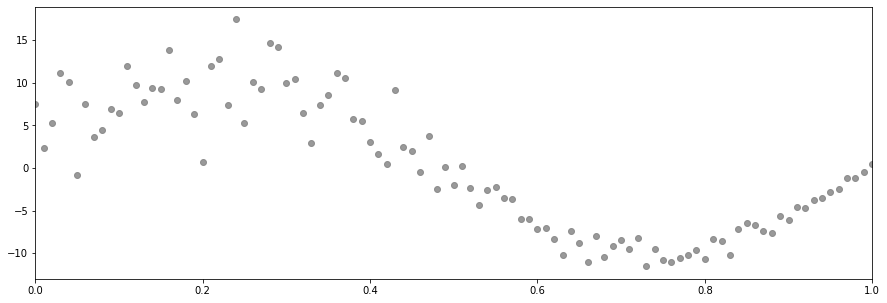

In [2]:
N = 101
X = np.linspace(0, 1, N)[:, None]

rand_samples = np.random.normal(0.0, 1.0, size=N)[:, None]
noise = rand_samples * (0.25 + 4 * (1-X))
signal = 10 * np.sin(2 * np.pi * X)
Y = signal + noise

def plot_distribution(X, Y, mean=None, std=None):
    plt.figure(figsize=(15, 5))
    if mean is not None:
        x = X.squeeze()
        for k in (1, 2):
            lb = (mean - k * std).squeeze()
            ub = (mean + k * std).squeeze()
            plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
        plt.plot(x, lb, color="silver")
        plt.plot(x, ub, color="silver")
        plt.plot(X, mean, color="black")
    plt.scatter(X, Y, color="gray", alpha=0.8)
    plt.xlim([0, 1])
    plt.show()


plot_distribution(X, Y)

## Train a standard GPR model

In [3]:
kernel = gf.kernels.Matern52()
base_model = gf.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
opt = gf.optimizers.Scipy()
opt_logs = opt.minimize(base_model.training_loss, base_model.trainable_variables, options=dict(maxiter=100))
print_summary(base_model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 69.4839 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.353  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  6.481  │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

This model struggles to describe the data, particularly towards higher values of x where the noise is low. 

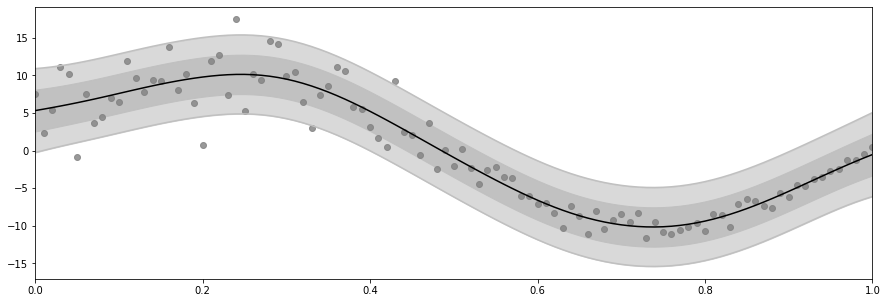

In [4]:
mean, var = base_model.predict_y(X)
plot_distribution(X, Y, mean.numpy(), np.sqrt(var.numpy()))

### Constructing a custom likelihood for a heteroskedastic GPR Model

This likelihood class allows the noise to vary linearly with the input location.

In [5]:
class LinearLikelihood(MultiLatentTFPConditional):

    def __init__(self, ndims: int = 1,  **kwargs):
        self.noise_gradient = Parameter(np.ones(ndims), prior=GRADIENT_PRIOR)
        self.constant_noise = Parameter(1.0, transform=positive(lower=MIN_NOISE_SCALE))

        def conditional_distribution(Fs) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
            loc = Fs[..., :1]
            scale = self.scale_transform(Fs[..., 1:])
            return tfp.distributions.Normal(loc, scale)

        super().__init__(latent_dim=2, conditional_distribution=conditional_distribution, ** kwargs)

    def scale_transform(self, X):
        """ Determine the likelihood variance at the specified input locations X. """

        noise_scale = tf.reduce_sum(tf.abs(X) * self.noise_gradient, axis=-1, keepdims=True)        
        return noise_scale  + self.constant_noise

Build the HetGPR model with the data and kernel, then model optimization proceeds as before

In [6]:
kernel = gf.kernels.Matern52()
likelihood = LinearLikelihood()
het_model = gf.models.het_GPR(data=(X, Y), kernel=kernel, likelihood=likelihood, mean_function=None)
opt = gf.optimizers.Scipy()
opt_logs = opt.minimize(het_model.training_loss, het_model.trainable_variables, options=dict(maxiter=100))
print_summary(het_model)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ het_GPR.kernel.variance           │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 115.69308348449829 │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ het_GPR.kernel.lengthscales       │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.4362062686725757 │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ het_GPR.likelihood.noise_gradient │ Parameter │ Identity    

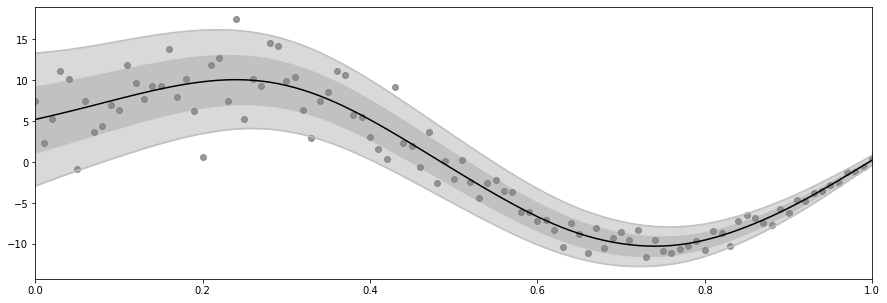

In [7]:
mean, var = het_model.predict_y(X)
plot_distribution(X, Y, mean.numpy(), np.sqrt(var.numpy()))

Next we can try a more complex quadratic noise model

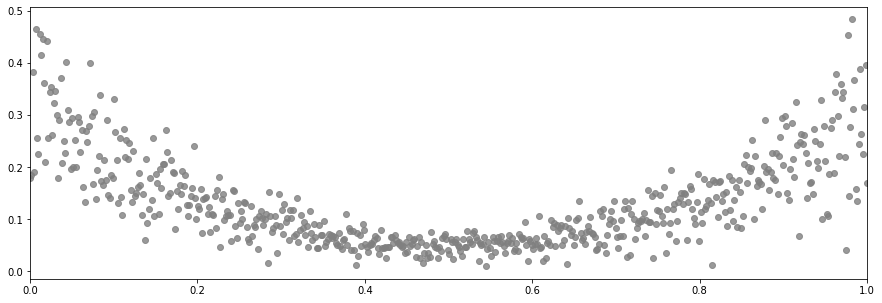

In [8]:
N = 600
# Build inputs X
rand_samples = np.random.normal(0.0, 1.0, size=N)[:, None]
X2 = np.linspace(0, 1, N)[:, None]
signal = (X2-0.5)**2 + 0.05
Y2 = signal * (1 + 0.3 * rand_samples)

plot_distribution(X2, Y2)

In [9]:
kernel = gf.kernels.Polynomial(degree=2)
base_model = gf.models.GPR(data=(X2, Y2), kernel=kernel, mean_function=None)
opt = gf.optimizers.Scipy()
opt_logs = opt.minimize(base_model.training_loss, base_model.trainable_variables, options=dict(maxiter=100))
print_summary(base_model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.12478   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.offset       │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.341036  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0022375 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

Once again we see that the assumption of a constant noise level is detrimental to the model performance.

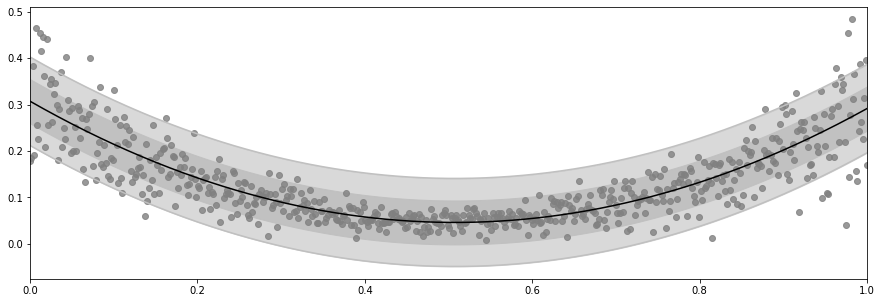

In [10]:
mean, var = base_model.predict_y(X2)
plot_distribution(X2, Y2, mean.numpy(), np.sqrt(var.numpy()))

When we have more data, we can afford to fit a more complex likelihood model. 

In [11]:
class QuadraticLikelihood(MultiLatentTFPConditional):
    """ Does what it says on the tin.  """
    
    def __init__(self, ndims: int = 1,  **kwargs):

        self.noise_gradient = Parameter(np.ones(ndims), prior=GRADIENT_PRIOR)
        self.noise_curvature = Parameter(np.ones(ndims), prior=GRADIENT_PRIOR)
        self.constant_noise = Parameter(1.0, transform=positive(lower=MIN_NOISE_SCALE))

        def conditional_distribution(Fs) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
            loc = Fs[..., :1]
            scale = self.scale_transform(Fs[..., 1:])
            return tfp.distributions.Normal(loc, scale)

        super().__init__(latent_dim=2, conditional_distribution=conditional_distribution, ** kwargs)

    def scale_transform(self, X):
        """ Determine the likelihood noise at the specified input locations. """
        
        x_terms = tf.abs(X) * self.noise_gradient + tf.math.square(X) * self.noise_curvature
        noise_scale = tf.reduce_sum(x_terms, axis=-1, keepdims=True)        
        return noise_scale + self.constant_noise

Build and train the model

In [12]:
kernel = gf.kernels.Polynomial(degree=2)
likelihood = QuadraticLikelihood()
quad_model = gf.models.het_GPR(data=(X2, Y2), kernel=kernel, likelihood=likelihood, mean_function=None)
opt = gf.optimizers.Scipy()
opt_logs = opt.minimize(quad_model.training_loss, quad_model.trainable_variables, options=dict(maxiter=100))
print_summary(quad_model)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ het_GPR.kernel.variance            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.085232496745681   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ het_GPR.kernel.offset              │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.3277427519828806  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ het_GPR.likelihood.noise_gradient  │ Parameter

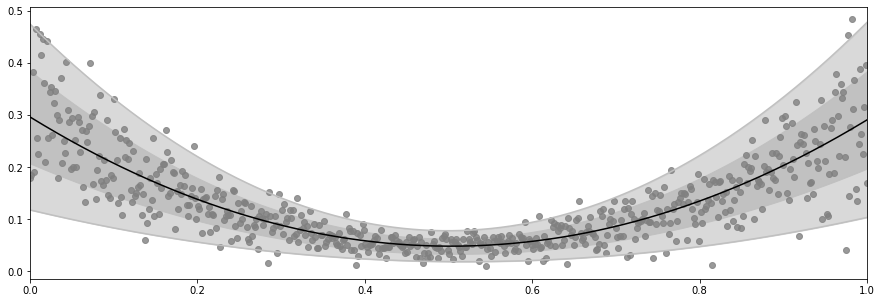

In [13]:
mean, var = quad_model.predict_y(X2)
plot_distribution(X2, Y2, mean.numpy(), np.sqrt(var.numpy()))

## Further reading

See [Kernel Identification Through Transformers](https://arxiv.org/abs/2106.08185) by Simpson et al.